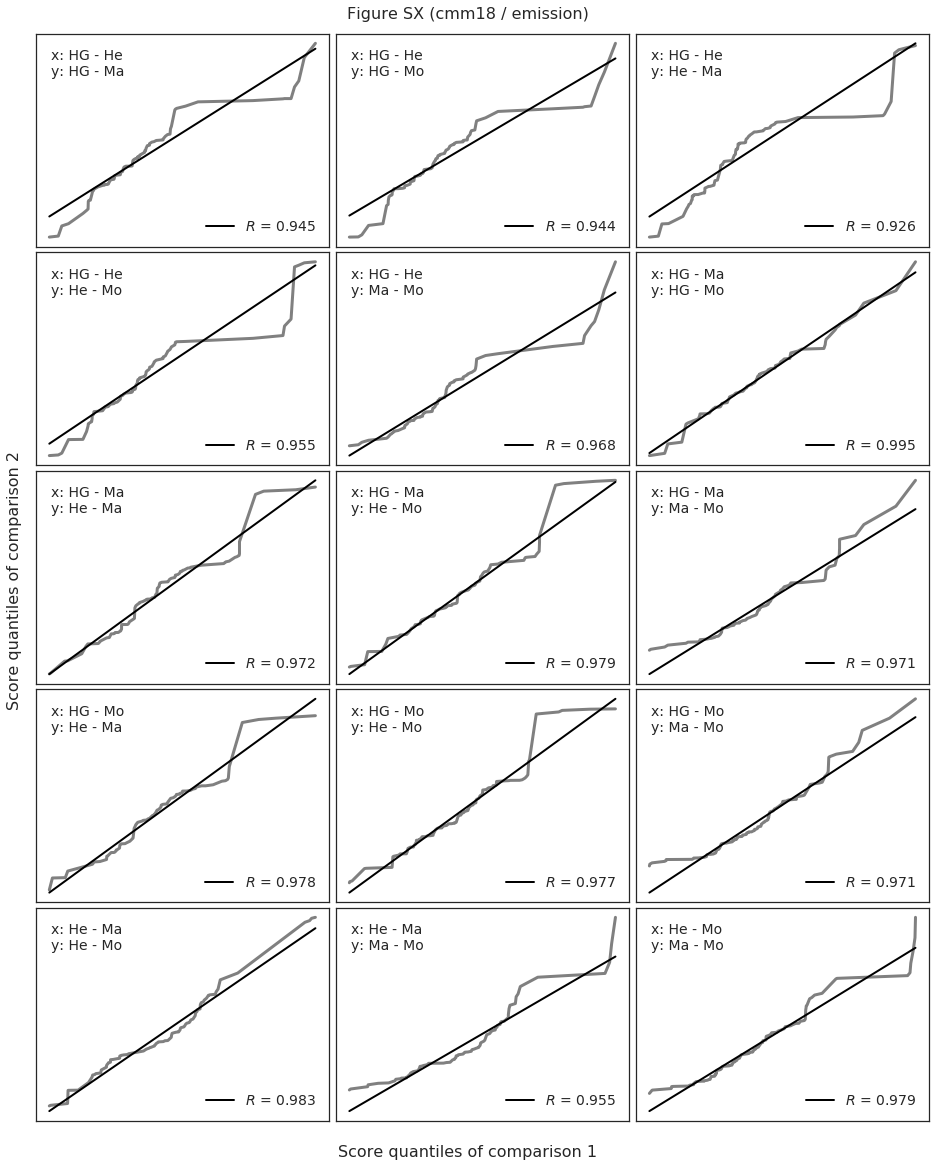

In [84]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import scipy.special as scisp
import scipy.stats.mstats as mstats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot several diagnostic plots
# that illustrate the adherence to
# the assumptions behind the
# Karlin-Altschul statistics

date = '20180604'

run_diagnostics = True
run_blockmax = True
# the QQ-Plots for the individual
# comparisons are not used at the moment,
# does not really offer insight
run_blockmax_comp = False

show_figures = True
save_figures = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr(all='raise')

scorings = ['emission', 'replicate']
resolution = {'lo': 150, 'hi': 350}
use_res = 'lo'

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def collect_block_maxima(fpaths, scoring, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        block_max = col.defaultdict(list)
        for fp in fpaths:
            segment = os.path.basename(fp).split('_')[3]
            with pd.HDFStore(fp, 'r') as hdf:
                load_keys = [k for k in hdf.keys() if k.startswith('/raw_scan/{}'.format(scoring))]
                for k in load_keys:
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    chrom = os.path.split(k)[-1]
                    data['comparison'] = data['sample1'] + '-VS-' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, 'nat_score_lnorm']
                        block_max[chrom + '-' + segment].append(float(sub.max()))
        ts = ti.ctime()
        with open(cache_file, 'w') as cache:
            js.dump({'timestamp': ts, 'data': block_max},
                     cache, sort_keys=True, indent=1)
    else:
        with open(cache_file, 'r') as cache:
            cached = js.load(cache)
            block_max = cached['data']
    return block_max


def collect_blockmax_comp(fpaths, scorings, segmentations, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        block_max = dict()
        for score in scorings:
            for seg in segmentations:
                if score in block_max:
                    block_max[score][seg] = col.defaultdict(list)
                else:
                    block_max[score] = dict()
                    block_max[score][seg] = col.defaultdict(list)
        for fp in fpaths:
            segment = os.path.basename(fp).split('_')[3]
            with pd.HDFStore(fp, 'r') as hdf:
                load_keys = [k for k in hdf.keys() if k.startswith('/raw_scan')]
                for k in load_keys:
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    _, _, scoring, chrom = k.split('/')
                    # deep_hsp_hg38_ecs10_CELLTYPE_He_vs_CELLTYPE_Mo.h5
                    fname = os.path.basename(fp).split('.')[0]
                    parts = fname.split('_')
                    s1 = parts[5]
                    s2 = parts[-1]
                    plot_comp = s1 + '_vs_' + s2
                    data['comparison'] = data['sample1'] + '_vs_' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, 'nat_score_lnorm']
                        block_max[scoring][segment][plot_comp].append(float(sub.max()))
        ts = ti.ctime()
        with open(cache_file, 'w') as cache:
            js.dump({'timestamp': ts, 'data': block_max},
                     cache, sort_keys=True, indent=1) 
    else:
        with open(cache_file, 'r') as cache:
            cached = js.load(cache)
            block_max = cached['data']
    return block_max


def sort_label_chroms(chroms):
    """
    """
    chrom_sort = []
    for c in chroms:
        try:
            chrom_num = int(c.strip('chr'))
            chrom_sort.append((chrom_num, c.strip('chr'), c))
        except ValueError:
            chrom_num = 23
            chrom_sort.append((chrom_num, 'X', c))
    return sorted(chrom_sort)
    

def plot_block_maxima(bmax, scoring, segment):
    """
    """
    load_keys = [k for k in bmax.keys() if segment in k]
    chrom_sort = sort_label_chroms([k.split('-')[0] for k in load_keys])
    plot_data = [bmax[t[2] + '-' + segment] for t in chrom_sort]
    x_labels = [t[1] for t in chrom_sort]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    medianprops = {'color': 'grey', 'linewidth': 2}
    boxprops = {'color': 'black', 'linewidth': 2}
    whiskerprops = {'color': 'black'}
    capprops = {'color': 'black'}
    flierprops = {'color': 'black', 'marker': 'o',
                  'markerfacecolor': 'white', 'markersize': 8,
                  'markeredgecolor': 'black'}
        
    bb = ax.boxplot(plot_data, notch=False, labels=x_labels,
                    boxprops=boxprops, medianprops=medianprops,
                    whiskerprops=whiskerprops, capprops=capprops,
                    flierprops=flierprops)
    
    max_y = max([item.get_ydata()[0] for item in bb['caps']])
        
    if max_y // 1000 > 1:
        ylim = np.ceil(max_y) + 100
    elif max_y // 1000 > 2:
        ylim = np.ceil(max_y) + 200
    else:
        ylim = np.ceil(max_y) + 50
    ax.set_ylim(-50, ylim)
    
    fig_tt = ax.set_title('Figure SX  ({} / {})'.format(segment, scoring), fontsize=16)
    #fig_tt.set_position((0.07, 1.02))
    
    ax.set_xlabel('Chromosomes', fontsize=16)
    ax.set_ylabel('Maximal scores (nats)', fontsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
    return fig, []


def plot_single_probplot(data, theo_dist, segmentation, scoring):
    """
    """
    dist = {'gumbel_r': stats.gumbel_r.fit,
            'expon': stats.expon.fit,
            'weibull_max': stats.weibull_max.fit,
            'genextreme': stats.genextreme.fit,
            'genpareto': stats.genpareto.fit}
    load_keys = [k for k in data.keys() if segmentation in k]
        
    plot_infos = sort_label_chroms([k.split('-')[0] for k in load_keys])
    plot_data = []
    [plot_data.extend(data[t[2] + '-' + segmentation]) for t in plot_infos]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    est_param = dist[theo_dist](plot_data)
    (osm, osr), (slope, inter, cod) = stats.probplot(plot_data, est_param,
                                                     dist=theo_dist, fit=True,
                                                     plot=ax)
    if osr.max() > 2000:
        tick_dist = 1000
    elif osr.max() > 1300:
        tick_dist = 500
    else:
        tick_dist = 250
    axis_ticks = np.arange(0, (max(osm.max(), osm.max()) // tick_dist) * tick_dist + tick_dist, tick_dist)
    y_ticks = np.arange(0, (max(osr.max(), osm.max()) // tick_dist) * tick_dist + tick_dist, tick_dist)
    ax.set_xticks(axis_ticks)
    ax.set_yticks(axis_ticks)
    # markers
    ax.get_lines()[0].set_color('grey')
    # trendline
    ax.get_lines()[1].set_color('black')
    ax.set_title('Figure X ({} / {})'.format(segmentation, scoring))

    ax.set_xlabel('Gumbel order statistic medians', fontsize=16)
    ax.set_ylabel('Observed maximal scores (nats)', fontsize=16)

    cod = str(np.round(cod, 3))
    ax.text(0.1, 0.9, '$N$ = ' + str(len(plot_data)), fontsize=16, transform=ax.transAxes)
    ax.text(0.1, 0.8, '$R$ = ' + cod, fontsize=16, transform=ax.transAxes)
    
    return fig, []
    

def plot_split_probplot(data, theo_dist, segmentation, scoring):
    """
    """
    dist = {'gumbel_r': stats.gumbel_r.fit,
            'expon': stats.expon.fit,
            'weibull_max': stats.weibull_max.fit,
            'genextreme': stats.genextreme.fit,
            'genpareto': stats.genpareto.fit}
    load_keys = [k for k in data.keys() if segmentation in k]
        
    total_subplots = len(load_keys) + 1
    num_cols = 4
    num_rows = total_subplots // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols,
                             sharex=False, sharey=False,
                             figsize=(14, 20))
    fig_title = 'Figure X ({} / {})'.format(segmentation, scoring)
    fig_xlabel = 'Theoretical quantiles'
    fig_ylabel = 'Observed values'
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ex_title = fig.text(0.5, 0.89, fig_title, ha='center', fontsize=16)
    ex_xlabel = fig.text(0.5, 0.1, fig_xlabel, ha='center', fontsize=16)
    ex_ylabel = fig.text(0.1, 0.5, fig_ylabel, va='center', rotation='vertical', fontsize=16)
    
    plot_infos = sort_label_chroms([k.split('-')[0] for k in load_keys])
    plot_data = [data[t[2] + '-' + segmentation] for t in plot_infos]
    
    
    x_labels = [t[1] for t in plot_infos]
    plot_infos.append((24, 'gen.', 'genome'))
    
    r, c = 0, 0
    gw_data = []

    dist_params = []
    for num, short, chrom in plot_infos:
        ax = axes[r, c]
        c += 1
        if c == 4:
            c = 0
            r += 1
        name = chrom + '-' + segmentation
        try:
            chrom_data = data[name]
            gw_data += chrom_data
        except KeyError:
            chrom_data = gw_data
        try:
            est_param = dist[theo_dist](chrom_data)
        except FloatingPointError:
            print('Skipping {}'.format(name))
            continue
        (osm, osr), (slope, inter, cod) = stats.probplot(chrom_data, est_param,
                                                         dist=theo_dist, fit=True, plot=ax)
        dist_params.append((chrom, inter, slope))
        ax.set_xticks([])
        ax.set_yticks([])
        # markers
        ax.get_lines()[0].set_color('grey')
        # trendline
        ax.get_lines()[1].set_color('black')
        ax.set_title('')
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        
#         if is_chrom:
#             ax.text(0.05, 0.9, name, fontsize=14, transform=ax.transAxes)
#         else:
#             ax.text(0.05, 0.9, 'k = {}'.format(name), fontsize=14, transform=ax.transAxes)
        
        cod = str(np.round(cod, 3))
        ax.text(0.6, 0.1, '$R$ = ' + cod, fontsize=12, transform=ax.transAxes)
           
    df = pd.DataFrame(dist_params, columns=['chrom', 'intercept', 'slope'])
                
    return fig, [ex_title, ex_xlabel, ex_ylabel]
    

def plot_qq_comp(plot_data, segmentation, score):
    """
    """
    total_subplots = len(plot_data.keys())
    total_subplots = int(scisp.comb(total_subplots, 2, repetition=False))
    num_cols = 3
    num_rows = total_subplots // num_cols
    fig, axes = plt.subplots(num_rows, num_cols,
                             sharex=False, sharey=False,
                             figsize=(16, 20))
    
    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    
    ex_title = fig.text(0.5, 0.89, 'Figure SX ({} / {})'.format(seg, score),
                        ha='center', fontsize=16)
    ex_xlabel = fig.text(0.5, 0.1, 'Score quantiles of comparison 1',
                         ha='center', fontsize=16)
    ex_ylabel = fig.text(0.1, 0.5, 'Score quantiles of comparison 2',
                         va='center', rotation='vertical', fontsize=16)
    
    plot_order = sorted(plot_data.keys())
    r, c = 0, 0
    done = set()
    for x_comp in plot_order:
        for y_comp in plot_order:
            if x_comp == y_comp:
                continue
            if (x_comp, y_comp) in done or (y_comp, x_comp) in done:
                continue
            label_vals = x_comp.split('_') + y_comp.split('_')
            label_vals = tuple([label_vals[i] for i in [0,2,3,5]])
            label = 'x: {} - {}\ny: {} - {}'.format(*label_vals)
            ax = axes[r, c]
            c += 1
            if c == 3:
                c = 0
                r += 1
            x_vals = sorted(plot_data[x_comp])
            y_vals = sorted(plot_data[y_comp])
            if len(x_vals) < len(y_vals):
                est_quant = np.linspace(0, 1, num=len(x_vals), endpoint=True, dtype=np.float16)
                y_vals = mstats.mquantiles(y_vals, prob=est_quant, alphap=0, betap=1)
            elif len(x_vals) > len(y_vals):
                est_quant = np.linspace(0, 1, num=len(y_vals), endpoint=True, dtype=np.float16)
                x_vals = mstats.mquantiles(x_vals, prob=est_quant, alphap=0, betap=1)                
            else:
                pass
            ax.set(adjustable='box')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.plot(x_vals, y_vals, c='grey', lw=3)
            # manually add best fit reg line
            slope, inter, rvalue, pv, graderr = stats.linregress(x_vals, y_vals)
            reg_yvals = np.array(x_vals) * slope + inter
            ax.plot(x_vals, reg_yvals, c='black', lw=2, label='$R$ = ' + str(np.round(rvalue, 3)) )
            ax.legend(loc='lower right', fontsize=14)
            # add label to plot
            ax.text(0.05, 0.8, label, fontsize=14, transform=ax.transAxes)
            done.add((x_comp, y_comp))
            done.add((y_comp, x_comp))
    return fig, []
   


def plot_joint_fit(hsps, rands):
    """
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    x_values = np.linspace(rands.min(), hsps.max(), 10000)
    
    hsps_loc, hsps_scale = stats.gumbel_r.fit(hsps)
    hsps_exp = stats.gumbel_r.pdf(x_values,
                                  loc=hsps_loc,
                                  scale=hsps_scale)
    
    rands_loc, rands_scale = stats.gumbel_l.fit(rands)
    rands_exp = stats.gumbel_l.pdf(x_values,
                                   loc=rands_loc,
                                   scale=rands_scale)
    
    _ = ax.hist(np.concatenate([hsps, rands]), normed=True,
                bins=100, alpha=0.4, color='blue',
                histtype='stepfilled', label='Observed / sampled')
    
    _ = ax.plot(x_values, rands_exp, lw=2, color='black', label='Fit (Gumbel [L])')

    _ = ax.plot(x_values, hsps_exp, lw=2, color='darkorange', label='Fit (Gumbel [R])')
    
    _ = ax.legend(loc='upper center', fontsize=12)
    _ = ax.set_title('Observed and random scores', fontsize=16)
    
    return fig, []

    
def plot_dist_fit(obs_data, title, gumbel_type):
    """
    """
    x_values = np.linspace(obs_data.min(), obs_data.max(), 100)
    
    if gumbel_type == 'right':
        gumbel_label = 'Fit (Gumbel [R])'
        gumbel_loc, gumbel_scale = stats.gumbel_r.fit(obs_data)
        gumbel_exp = stats.gumbel_r.pdf(x_values,
                                        loc=gumbel_loc,
                                        scale=gumbel_scale)
    else:
        gumbel_label = 'Fit (Gumbel [L])'
        gumbel_loc, gumbel_scale = stats.gumbel_l.fit(obs_data)
        gumbel_exp = stats.gumbel_l.pdf(x_values,
                                        loc=gumbel_loc,
                                        scale=gumbel_scale)
    
    norm_loc, norm_scale = stats.norm.fit(obs_data)
    norm_exp = stats.norm.pdf(x_values,
                              loc=norm_loc,
                              scale=norm_scale)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    _ = ax.hist(obs_data, normed=True, bins=100, alpha=0.5,
                histtype='stepfilled', color='blue', label='Observed')

    _ = ax.plot(x_values, norm_exp, lw=4, color='black', label='Fit (Norm)')

    _ = ax.plot(x_values, gumbel_exp, lw=5, color='darkorange',
                label=gumbel_label, alpha=0.8)

    _ = ax.legend(loc='upper center', fontsize=12)
    _ = ax.set_title(title, fontsize=16)
    
    return fig, []


def plot_bin_scores(hsps, rands):
    """
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    
    joint_values = np.concatenate([hsps, rands])
    
    x_values = np.linspace(joint_values.min(), joint_values.max(), 100)
    
    hsp_loc, hsp_scale = stats.norm.fit(hsps)
    hsp_exp = stats.norm.pdf(x_values,
                             loc=hsp_loc,
                             scale=hsp_scale)
    
    rand_loc, rand_scale = stats.norm.fit(rands)
    rand_exp = stats.norm.pdf(x_values,
                              loc=rand_loc,
                              scale=rand_scale)
    
    
    ax.hist(joint_values, normed=True, bins=100, alpha=0.5,
            histtype='stepfilled', color='blue', label='Observed / random')
    
    ax.plot(x_values, rand_exp, color='black',
            alpha=0.8, lw=4)
    
    ax.plot(x_values, hsp_exp, color='darkorange',
            alpha=0.8, lw=4)

    return fig, []


if run_diagnostics:
    run_files = []
    segmentations = set()
    for root, dirs, files in os.walk(data_root):
        if root.endswith('hsp_run'):
            for f in files:
                if not f.endswith('.h5'):
                    continue
                segmentations.add(f.split('_')[3])
                run_files.append(os.path.join(root, f))

    if run_blockmax:        
        for score in scorings:
            score_cache = os.path.join(cache_dir, '{}_blockmax_{}.json'.format(date, score))
            bm = collect_block_maxima(run_files, score, score_cache)
            
            for seg in segmentations:
                
                if seg != 'cmm18' or score != 'emission':
                    continue
                                
                fig, exart = plot_block_maxima(bm, score, seg)
                
                if save_figures:
                    outname = 'fig_SX_blockmax_{}-{}'.format(seg, score)
                    
                    outpath = os.path.join(fig_supp, outname + '.pdf')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                    
                    outpath = os.path.join(fig_supp, outname + '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=resolution[use_res])

                fig, exart = plot_single_probplot(bm, 'gumbel_r', seg, score)
                if save_figures:
                    outname = 'fig_X_pplot_{}-{}'.format(seg, score)
                    
                    outpath = os.path.join(fig_main, outname + '.pdf')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                    
                    outpath = os.path.join(fig_main, outname + '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=resolution[use_res])
    
    if run_blockmax_comp:
        # check that individual comparisons
        # give rise to roughly the same distribution
        score_cache = os.path.join(cache_dir, '{}_blockmax_comp.json'.format(date))
        bm = collect_blockmax_comp(run_files, scorings, segmentations, score_cache)
        
        for score in scorings:
            
            if score != 'emission':
                continue
            
            for seg in segmentations:
                
                if seg != 'cmm18':
                    continue
                
                fig, exart = plot_qq_comp(bm[score][seg], seg, score)
                if save_figures:
                    outname = ''
                    
                    outpath = os.path.join(fig_supp, 'fig_X_supp_qqplot_{}.svg'.format(score))
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                    
                    outpath = outpath.replace('.svg', '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=resolution[use_res])
        